## 24W-COM SCI-M148 Homework 2 Coding Question

Name: Krish Patel

UID: 605 796 227

### **Submission Guidelines**
1. Please fill in your name and UID above.

2. Please submit a **PDF printout** of your Jupyter Notebook to **Gradescope**. If you have any trouble accessing Gradescope, please let a TA know ASAP.  

3. As the PDF can get long, please tag the respective sections to ensure the readers know where to look.  

# Overview
This coding question is about training and explaining what neural networks are doing with LIME (short for Local Interpretable Model-agnostic Explanations).

We use a small image dataset called MNIST. It is a dataset of handwritten digits that is commonly used for training image classification models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

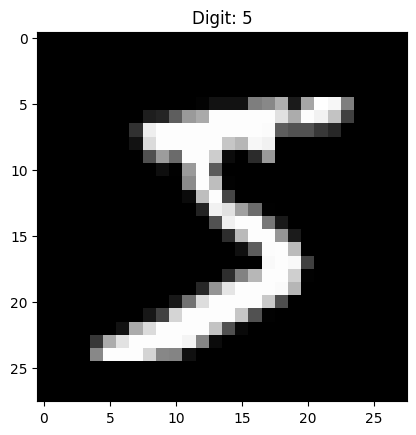

In [3]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

# Setup a Pipeline
Here we make a pipeline for processing the images where basically we flatten the image back to 1d vectors and then use a neural network with one hidden layer.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_nn_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('NN', MLPClassifier()) # This is a neural network with 1 hidden layer
    ])

Now, let's do the train-test split to have 55% data in the train set with the random state set to 0:

In [10]:
print("Shape of X_vec: {}".format(X_vec.shape))
percent = 0.55

X_train, X_test, y_train, y_test = X_vec[:int(percent*len(X_vec))], X_vec[int(percent*len(X_vec)):], y_vec[:int(percent*len(X_vec))], y_vec[int(percent*len(X_vec)):]

Shape of X_vec: (70000, 28, 28, 3)


In [12]:
simple_nn_pipeline.fit(X_train, y_train)


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x14ba2f050>),
                ('Flatten Image', <__main__.PipeStep object at 0x30fad7dd0>),
                ('NN', MLPClassifier())])

Now, let's get the training and test scores.

In [13]:
print('Training set score: ' + str( simple_nn_pipeline.score(X_train, y_train)))
print('Test set score: ' + str( simple_nn_pipeline.score(X_test, y_test)))

Training set score: 1.0
Test set score: 0.9731111111111111


In [14]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    %pip install lime
    import lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=365a2617c15910d2e1d352c7417eddaac734208561d9ebfbd6c65485996cefc5
  Stored in directory: /Users/krishpatel/Library/Caches/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_nn_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100%|██████████| 10000/10000 [00:01<00:00, 5487.39it/s]

CPU times: user 11.7 s, sys: 800 ms, total: 12.5 s
Wall time: 1.93 s


Text(0.5, 1.0, 'Positive/Negative Regions for 4')

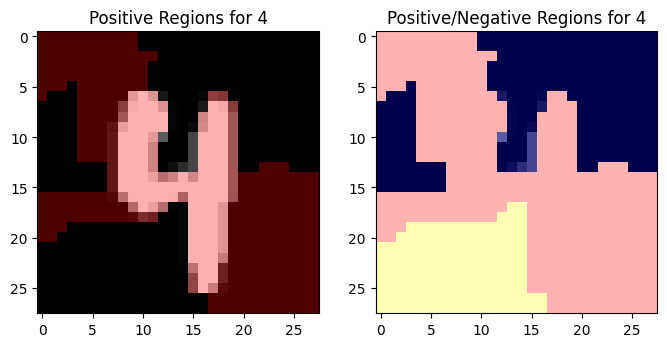

In [17]:
temp, mask = explanation.get_image_and_mask(y_test.values[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.values[0]))
temp, mask = explanation.get_image_and_mask(y_test.values[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.values[0]))

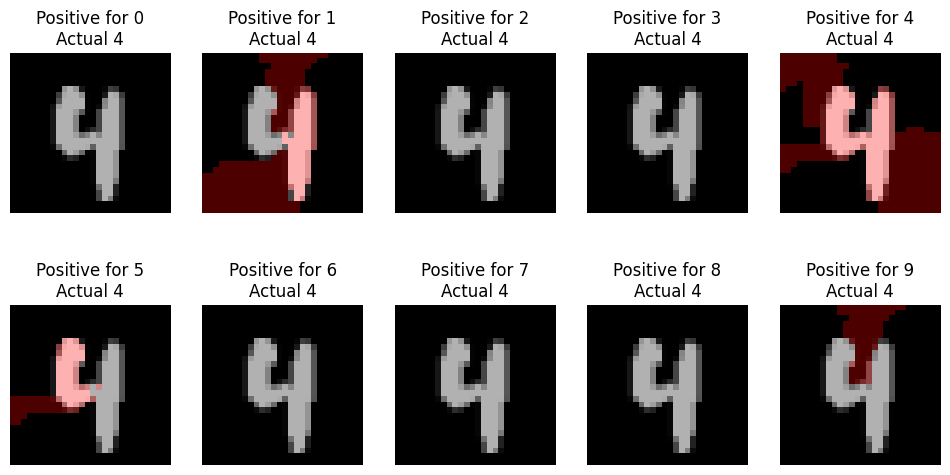

In [18]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.values[0]))
    c_ax.axis('off')

# Gaining Insight
Can we find an explanation for a classification the algorithm got wrong

In [19]:
pipe_pred_test = simple_nn_pipeline.predict(X_test)
np.random.seed(0)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test.values[wrong_idx], pipe_pred_test[wrong_idx]))

Using #23553 where the label was 4 and the pipeline predicted 9


In [20]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_nn_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100%|██████████| 10000/10000 [00:01<00:00, 5392.52it/s]

CPU times: user 12.2 s, sys: 782 ms, total: 13 s
Wall time: 1.92 s


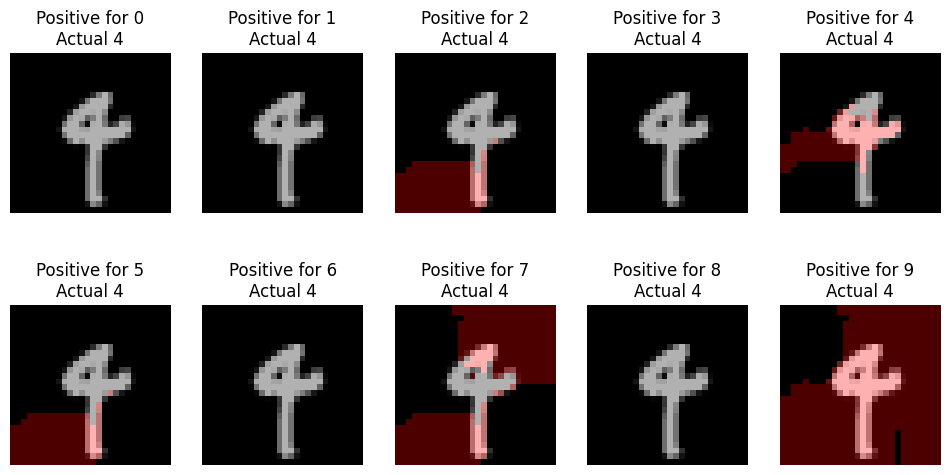

In [21]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.values[wrong_idx]))
    c_ax.axis('off')

Explain why the model misclassified this example based on the output of LIME:

According to the picture above, we can see that the model classified the handwritten digit 4 as a 9. From the LIME used earlier for the correctly predicted 4, we can see that the red portion is used to classify if the digit is a 9. For this specific example, which features a closed 4, the portion that contributes to the classification of 9 is highlighted, and thus, the classifier labels it as a 9 instead. The most likely explanation of the misclassification, thus, is the closed part of the 4 which is what the model uses to classify a 9 from the LIME analysis for the open 4 above.